##**Imports**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
train_df = pickle.load(open('/content/drive/MyDrive/Copy of train_df_prep.pkl','rb'))

In [3]:
!pip install transformers 

     |████████████████████████████████| 3.4 MB 4.2 MB/s 
     |████████████████████████████████| 895 kB 55.2 MB/s 
     |████████████████████████████████| 596 kB 60.2 MB/s 
     |████████████████████████████████| 3.3 MB 48.7 MB/s 
     |████████████████████████████████| 61 kB 411 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer,DistilBertTokenizer
tokenizer2 = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',add_prefix_space=True)          # tokenizer for distill bert 

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [4]:
from transformers import BertTokenizer,DistilBertTokenizer                                                   # tokenizer for bert 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',add_prefix_space=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [5]:
from transformers import TFBertForQuestionAnswering,TFDistilBertForQuestionAnswering
dbert= TFDistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
bert= TFBertForQuestionAnswering.from_pretrained('bert-base-uncased')


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForQuestionAnswering.

Some layers of TFBertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Softmax,Dense,Activation,Dropout
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm import tqdm 
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger,EarlyStopping,ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D,Embedding,LSTM,Embedding,Input,Softmax,Dense,Activation,Dropout
# from fuzzywuzzy import fuzz
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import time 
from time import time
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
x_train, x_val , y_train , y_val = train_test_split(train_df[['text','sentiment']],train_df['selected_text'],test_size=0.2, random_state=42)
x_train.shape, x_val.shape , y_train.shape , y_val.shape

((21976, 2), (5495, 2), (21976,), (5495,))

**metric**

In [ ]:
def jaccard(str1,str2): 
  a=set(str1.lower().split()) 
  b=set(str2.lower().split())
  c=a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

## **Models_comparision**

###**pre_processing**

**text to input_ids** 

In [9]:
def train_prep(MAX_LEN,tokenizer):
                                                                          # train input_ids and attten_mask  start and end tokens indexes 
  count = x_train.shape[0]
  input_ids = np.zeros((count,MAX_LEN),dtype='int32')
  attention_mask = np.zeros((count,MAX_LEN),dtype='int32')
  start_tokens = np.zeros((count,MAX_LEN),dtype='int32')
  end_tokens = np.zeros((count,MAX_LEN),dtype='int32')
  toks_all = []

  count=0
  for i,each in tqdm(enumerate(x_train.values)):
    val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=MAX_LEN,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
    input_ids[i] = val['input_ids']
    attention_mask[i] = val['attention_mask']
    text1 = " "+" ".join(each[0].split())
    text2 = " ".join(y_train.values[i].split())
    
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ':
      chars[idx-1] = 1


    enc = tokenizer.encode(text1) 
    offsets = []; idx=0
    for t in enc:
      w=tokenizer.decode([t])
      offsets.append((idx,idx+len(w)))
      idx += len(w)

    toks = []
    for c,(a,b) in enumerate(offsets):
      sm = np.sum(chars[a:b])
      if sm>0:
        toks.append(c)
    toks_all.append(toks)    
    if len(toks)>0:
      count+=1
      start_tokens[i,(toks[0])+1] = 1
      end_tokens[i,(toks[-1])+1] = 1 

  return toks_all,input_ids,attention_mask,start_tokens,end_tokens

In [11]:
toks_all,input_ids,attention_mask,start_tokens,end_tokens = train_prep(MAX_LEN=92,tokenizer=tokenizer)      # train ids 

In [ ]:
def valid_prep(MAX_LEN,tokenizer):
  
  count = y_val.shape[0]
  input_ids_val = np.zeros((count,MAX_LEN),dtype='int32')
  attention_mask_val = np.zeros((count,MAX_LEN),dtype='int32')
  start_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')
  end_tokens_val = np.zeros((count,MAX_LEN),dtype='int32')

  count=0
  for i,each in tqdm(enumerate(x_val.values)):
    val = tokenizer.encode_plus(each[0],each[1],add_special_tokens=True,max_length=MAX_LEN,return_attention_mask=True,pad_to_max_length=True,return_tensors='tf',verbose=False)
    input_ids_val[i] = val['input_ids']
    attention_mask_val[i] = val['attention_mask']
    text1 = " "+" ".join(each[0].split())
    text2 = " ".join(y_val.values[i].split())
    #finding the start index 
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ':
      chars[idx-1] = 1


    enc = tokenizer.encode(text1) 
    offsets = []; idx=0
    for t in enc:
      w=tokenizer.decode([t])
      offsets.append((idx,idx+len(w)))
      idx += len(w)

    toks = []
    for c,(a,b) in enumerate(offsets):
      sm = np.sum(chars[a:b])
      if sm>0:
        toks.append(c)
    toks_all.append(toks)    
    if len(toks)>0:
      count+=1
      start_tokens_val[i,(toks[0])+1] = 1
      end_tokens_val[i,(toks[-1])+1] = 1

  return input_ids_val,attention_mask_val,start_tokens_val,end_tokens_val

In [ ]:
input_ids_val,attention_mask_val,start_tokens_val,end_tokens_val = valid_prep(MAX_LEN=92,tokenizer=tokenizer)             # valid ids 

5495it [00:09, 586.80it/s]


In [15]:
input_data = (input_ids,attention_mask)
output_data = (start_tokens,end_tokens)
val = (input_ids_val,attention_mask_val)
output_val = (start_tokens_val,end_tokens_val)
val_data = (val,output_val)

train_dataset = tf.data.Dataset.from_tensor_slices((input_data, output_data)).shuffle(buffer_size=1024).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(32)

###**DBERT_QA+dense**

In [ ]:
MAX_LEN=128                                                                                                            # reload
def create_model():
  input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
  input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
  start_scores,end_scores = dbert(input1,attention_mask = input2).values()
  dense1 = Dense(units=MAX_LEN,activation='relu',name='dense1',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(start_scores)
  softmax1 = Activation('softmax')(dense1)
  dense2 = Dense(units=MAX_LEN,activation='relu',name='dense2',kernel_regularizer = tf.keras.regularizers.L2(l2=0.00001))(end_scores)
  softmax2 = Activation('softmax')(dense2)
  model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08, clipnorm=1.0)
  model.compile(optimizer=opt,loss='categorical_crossentropy')
  return model

model = create_model()

model.load_weights('/content/drive/MyDrive/Copy of DBertQA_model.hdf5')  

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_id (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_for_question_an  multiple            66364418    ['input_id[0][0]',               
 swering (TFDistilBertForQuesti                                   'attention_mask[0][0]']         
 onAnswering)                                                                                     
                                                                                            

**predictions**

In [ ]:
val = (input_ids_val,attention_mask_val)
start_val , end_val = model.predict(val)                # validation predictions 

pred_values_val=[]
for i in tqdm(range(start_val.shape[0])):
  a = np.argmax(start_val[i])
  b = np.argmax(end_val[i])
  text1 = " "+" ".join(x_val['text'].values[i].split())               # pred_answer
  enc = tokenizer2.encode(text1)
  val = tokenizer2.decode(enc[a:b+1])
  pred_values_val.append(val)
for i in range(len(pred_values_val)):
  pred_values_val[i] = pred_values_val[i].replace('[SEP]','')  # removing [sep] token 

scores_val=[]
x_val['pred_text'] = pred_values_val
x_val['selected_text'] = y_val.values
scores=[]
for i in tqdm(range(x_val.shape[0])):
  scores_val.append(jaccard(x_val['pred_text'].values[i],x_val['selected_text'].values[i]))           # jaccard score calculations
x_val['jaccard']=scores_val

In [ ]:
x_val.head(20)

,text,sentiment,pred_text,selected_text,jaccard
7917,this is my update,neutral,this is my update,this is my update,1.000000
15845,whaaat i still have next week,neutral,whaaat i still have next week,whaaat i still have next week,1.000000
21278,happy birthday little sister of mine also go...,positive,happy birthday little sister of mine also good...,happy birthday little sister of mine,0.600000
22338,do some research for my article,neutral,do some research for my article,do some research for my article,1.000000
22474,are you okay,neutral,are you okay,are you okay,1.000000
21560,turned my alarm off this morning because i tho...,negative,turned my alarm off this morning because i tho...,fail,0.043478
8870,elaines my online mommy too she gives good a...,positive,she gives good advice,she gives good advice,1.000000
22030,good ABUSE homie hahahahaha thats what im tal...,positive,good abuse ho,good,0.333333
6693,there are days of summervac school comes alo...,neutral,there are days of summervac school comes along...,the annual problem of r generation is finding ...,0.590909
15718,i have tea have just found a picture of the b...,neutral,i have tea have just found a picture of the bi...,i have tea have just found a picture of the b...,1.000000


In [ ]:
print('Mean training Jaccard score:',np.mean(x_val['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(x_val[x_val['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(x_val[x_val['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(x_val[x_val['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.6101828553749853
Mean jaccard score for positive sentiment tweets: 0.3745756631390002
Mean jaccard score for negative sentiment tweets 0.35826182939871276
Mean jaccard score for neutral sentiment tweets 0.9672193330825384


###**DBERT_QA+conv1d**

In [ ]:
MAX_LEN =92
def DBERT_CNN():
  input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
  input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
  start_scores,end_scores = dbert(input1,attention_mask = input2).values()

  drop1 = Dropout(0.1)(start_scores)
  drop1  = tf.expand_dims(drop1,axis=-1) 
  layer1 = tf.keras.layers.Conv1D(1,1)(drop1)                                          # conv1d instead dense
  layer1= Flatten()(layer1)
  softmax1 = Activation('softmax')(layer1)

  drop2 = Dropout(0.1)(end_scores)
  drop2  = tf.expand_dims(drop2,axis=-1)
  layer2 = tf.keras.layers.Conv1D(1,1)(drop2)                                         # conv1d 
  layer2 = Flatten()(layer2)
  softmax2 = Activation('softmax')(layer2)

  model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2])

  opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0)
  model.compile(optimizer=opt,loss='categorical_crossentropy')
  
  return model

model = DBERT_CNN()

model.load_weights('/content/drive/MyDrive/DBert_CNN_QA_model.hdf5') 

**predictions**

In [ ]:
val = (input_ids_val,attention_mask_val)
start_val , end_val = model.predict(val)                # validation predictions 

pred_values_val=[]
for i in tqdm(range(start_val.shape[0])):
  a = np.argmax(start_val[i])
  b = np.argmax(end_val[i])
  text1 = " "+" ".join(x_val['text'].values[i].split())               # pred_answer
  enc = tokenizer2.encode(text1)
  val = tokenizer2.decode(enc[a:b+1])
  pred_values_val.append(val)
for i in range(len(pred_values_val)):
  pred_values_val[i] = pred_values_val[i].replace('[SEP]','')  # removing [sep] token 

scores_val=[]
x_val['pred_text'] = pred_values_val
x_val['selected_text'] = y_val.values
scores=[]
for i in tqdm(range(x_val.shape[0])):
  scores_val.append(jaccard(x_val['pred_text'].values[i],x_val['selected_text'].values[i]))           # jaccard score calculations
x_val['jaccard']=scores_val

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_id (InputLayer)          [(None, 92)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 92)]         0           []                               
                                                                                                  
 tf_distil_bert_for_question_an  TFQuestionAnswering  66364418   ['input_id[0][0]',               
 swering (TFDistilBertForQuesti  ModelOutput(loss=No              'attention_mask[0][0]']         
 onAnswering)                   ne, start_logits=(N                                               
                                one, 92),                                                   

In [ ]:
x_val.head(20)

,text,sentiment,pred_text,selected_text,jaccard
7917,this is my update,neutral,this is my update,this is my update,1.000000
15845,whaaat i still have next week,neutral,whaaat i still have next week,whaaat i still have next week,1.000000
21278,happy birthday little sister of mine also go...,positive,happy birthday little,happy birthday little sister of mine,0.500000
22338,do some research for my article,neutral,do some research for my article,do some research for my article,1.000000
22474,are you okay,neutral,are you okay,are you okay,1.000000
21560,turned my alarm off this morning because i tho...,negative,turned my alarm off this morning because i tho...,fail,0.043478
8870,elaines my online mommy too she gives good a...,positive,good advice,she gives good advice,0.500000
22030,good ABUSE homie hahahahaha thats what im tal...,positive,good,good,1.000000
6693,there are days of summervac school comes alo...,neutral,there are days of summervac school comes along...,the annual problem of r generation is finding ...,0.590909
15718,i have tea have just found a picture of the b...,neutral,i have tea have just found a picture of the bi...,i have tea have just found a picture of the b...,1.000000


In [ ]:
print('Mean training Jaccard score:',np.mean(x_val['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(x_val[x_val['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(x_val[x_val['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(x_val[x_val['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.6107009628532492
Mean jaccard score for positive sentiment tweets: 0.36968854032180715
Mean jaccard score for negative sentiment tweets 0.35657944122532753
Mean jaccard score for neutral sentiment tweets 0.9734503241642162


###**BERT_QA+conv1d**

In [ ]:
def BERT_QA():
  MAX_LEN = 92
  input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
  input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
  start_scores,end_scores = bert(input1,attention_mask = input2).values()

  drop1 = Dropout(0.5)(start_scores)
  drop1  = tf.expand_dims(drop1,axis=-1)
  layer1 = tf.keras.layers.Conv1D(1,1)(drop1)                                          # conv1d instead dense
  layer1= Flatten()(layer1)
  softmax1 = Activation('softmax')(layer1)

  drop2 = Dropout(0.5)(end_scores)
  drop2  = tf.expand_dims(drop2,axis=-1)
  layer2 = tf.keras.layers.Conv1D(1,1)(drop2)                                         # conv1d 
  layer2 = Flatten()(layer2)
  softmax2 = Activation('softmax')(layer2)

  model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2]) 
  opt = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
  model.compile(optimizer=opt,loss='categorical_crossentropy')

  return model 

model = BERT_QA()
model.load_weights('/content/drive/MyDrive/Copy of Copy of Bert_CNN_QA_model.hdf5') 


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_id (InputLayer)          [(None, 92)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 92)]         0           []                               
                                                                                                  
 tf_bert_for_question_answering  TFQuestionAnswering  108893186  ['input_id[0][0]',               
  (TFBertForQuestionAnswering)  ModelOutput(loss=No               'attention_mask[0][0]']         
                                ne, start_logits=(N                                               
                                one, 92),                                                   

**train_performance**

In [ ]:
input_data = (input_ids,attention_mask)
start , end = model.predict(input_data)

pred_values=[]
for i in tqdm(range(start.shape[0])):
  a = np.argmax(start[i])
  b = np.argmax(end[i])
  text1 = " "+" ".join(x_train['text'].values[i].split())
  enc = tokenizer.encode(text1)
  val = tokenizer.decode(enc[a:b+1])
  pred_values.append(val)
for i in range(len(pred_values)):
  pred_values[i] = pred_values[i].replace('[SEP]','')  # removing [sep] token 

x_train['pred_text'] = pred_values
x_train['selected_text'] = y_train.values
scores=[]
for i in tqdm(range(x_train.shape[0])):
  scores.append(jaccard(x_train['pred_text'].values[i],x_train['selected_text'].values[i]))   
x_train['jaccard']=scores 

100%|██████████| 21976/21976 [00:18<00:00, 1181.78it/s]


In [ ]:
x_train.head(20)

,text,sentiment,pred_text,selected_text,jaccard
22723,awe thanks,positive,awe thanks,awe thanks,1.000000
1231,on my way to dazzle bar,neutral,on my way to dazzle bar,on my way to dazzle bar,1.000000
531,terrible haha that was new the fact that he c...,neutral,terrible haha that was new the fact that he co...,he couldnt do it should have cost his part,0.428571
22325,fun day with boo short but fun,positive,fun day,fun day,1.000000
18214,of course im almost there and theres traffic,neutral,of course im almost there and theres traffic,of course im almost there and theres traffic,1.000000
15839,im nauseous i need a yogurt or something,negative,im nauseous,nauseous,0.500000
17356,omg my head still hurts i need to get my comic...,negative,hurts i,hurts,0.500000
12502,my body is aching i can barely movebut its wor...,negative,my body is aching i can barely movebu,barely,0.125000
25623,oh no my fan broke noooooooooooo great now i ...,negative,##oooooooooo,noooooooooooo,0.000000
12306,are you tinkn the people on the street in ny ...,neutral,are you tinkn the people on the street in ny w...,are you tinkn the people on the street in ny w...,1.000000


In [ ]:
print('Mean training Jaccard score:',np.mean(x_train['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(x_train[x_train['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(x_train[x_train['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(x_train[x_train['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.6923385846931966
Mean jaccard score for positive sentiment tweets: 0.4911920594886255
Mean jaccard score for negative sentiment tweets 0.5105602910554877
Mean jaccard score for neutral sentiment tweets 0.9748906057382648


**Validation_performance**

In [ ]:
val = (input_ids_val,attention_mask_val)
start_val , end_val = model.predict(val)                # validation predictions 

pred_values_val=[]
for i in tqdm(range(start_val.shape[0])):
  a = np.argmax(start_val[i])
  b = np.argmax(end_val[i])
  text1 = " "+" ".join(x_val['text'].values[i].split())               # pred_answer
  enc = tokenizer2.encode(text1)
  val = tokenizer2.decode(enc[a:b+1])
  pred_values_val.append(val)
for i in range(len(pred_values_val)):
  pred_values_val[i] = pred_values_val[i].replace('[SEP]','')  # removing [sep] token 

scores_val=[]
x_val['pred_text'] = pred_values_val
x_val['selected_text'] = y_val.values
scores=[]
for i in tqdm(range(x_val.shape[0])):
  scores_val.append(jaccard(x_val['pred_text'].values[i],x_val['selected_text'].values[i]))           # jaccard score calculations
x_val['jaccard']=scores_val

In [ ]:
x_val.head(20)

,text,sentiment,pred_text,selected_text,jaccard
7917,this is my update,neutral,this is my update,this is my update,1.000000
15845,whaaat i still have next week,neutral,whaaat i still have next week,whaaat i still have next week,1.000000
21278,happy birthday little sister of mine also go...,positive,happy birthday,happy birthday little sister of mine,0.333333
22338,do some research for my article,neutral,do some research for my article,do some research for my article,1.000000
22474,are you okay,neutral,are you okay,are you okay,1.000000
21560,turned my alarm off this morning because i tho...,negative,,fail,0.000000
8870,elaines my online mommy too she gives good a...,positive,good advice,she gives good advice,0.500000
22030,good ABUSE homie hahahahaha thats what im tal...,positive,good,good,1.000000
6693,there are days of summervac school comes alo...,neutral,there are days of summervac school comes along...,the annual problem of r generation is finding ...,0.590909
15718,i have tea have just found a picture of the b...,neutral,i have tea have just found a picture of the bi...,i have tea have just found a picture of the b...,1.000000


In [ ]:
print('Mean training Jaccard score:',np.mean(x_val['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(x_val[x_val['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(x_val[x_val['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(x_val[x_val['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.6125855286682741
Mean jaccard score for positive sentiment tweets: 0.3721725002502277
Mean jaccard score for negative sentiment tweets 0.36163770200012707
Mean jaccard score for neutral sentiment tweets 0.972672837052568


**observations**
1. bertQA performing slight better than distill bertQA
2. bertQA have train jaccard 0.69233 and validation jaccard 0.6125 . so there isn't much over fitting .

##**Quantization**

In [ ]:
 !pip install -q tensorflow
 !pip install -q tensorflow-model-optimization  

     |████████████████████████████████| 213 kB 5.2 MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot
import tempfile

In [ ]:
def BERT_QA():
  MAX_LEN = 92
  input1 = Input(shape=(MAX_LEN,),name='input_id',dtype=tf.int32)
  input2 = Input(shape=(MAX_LEN,),name='attention_mask',dtype=tf.int32)
  start_scores,end_scores = bert(input1,attention_mask = input2).values()

  drop1 = Dropout(0.5)(start_scores)
  drop1  = tf.expand_dims(drop1,axis=-1)
  layer1 = tf.keras.layers.Conv1D(1,1)(drop1)                                          # conv1d instead dense
  layer1= Flatten()(layer1)
  softmax1 = Activation('softmax')(layer1)

  drop2 = Dropout(0.5)(end_scores)
  drop2  = tf.expand_dims(drop2,axis=-1)
  layer2 = tf.keras.layers.Conv1D(1,1)(drop2)                                         # conv1d 
  layer2 = Flatten()(layer2)
  softmax2 = Activation('softmax')(layer2)

  model = Model(inputs=[input1,input2],outputs=[softmax1,softmax2]) 
  opt = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
  model.compile(optimizer=opt,loss='categorical_crossentropy')

  return model 
model = BERT_QA()
model.load_weights('/content/drive/MyDrive/Copy of Copy of Bert_CNN_QA_model.hdf5') 

In [ ]:
# model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
#saving converted model in "converted_model.tflite" file
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgw8ct29s/assets


INFO:tensorflow:Assets written to: /tmp/tmpgw8ct29s/assets
INFO:absl:Using new converter: If you encounter a problem please file a bug. You can opt-out by setting experimental_new_converter=False


434567104

In [ ]:
# model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 

tflite_quant_model = converter.convert()
#saving converted model in "converted_quant_model.tflite" file
open("converted_quant_model.tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: /tmp/tmpiz72wso1/assets


INFO:tensorflow:Assets written to: /tmp/tmpiz72wso1/assets
INFO:absl:Using new converter: If you encounter a problem please file a bug. You can opt-out by setting experimental_new_converter=False


109450336

In [ ]:
import os
print("Float model in Mb:", os.path.getsize('converted_model.tflite') / float(2**20))
print("Quantized model in Mb:", os.path.getsize('converted_quant_model.tflite') / float(2**20))
print("Compression ratio:", os.path.getsize('converted_model.tflite')/os.path.getsize('converted_quant_model.tflite'))

Float model in Mb: 414.43548583984375
Quantized model in Mb: 104.38265991210938
Compression ratio: 3.970348007885602


In [ ]:
import tensorflow as tf
import pickle
# val = pickle.load(open('/content/drive/MyDrive/quantization/val.pkl','rb'))
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/quantization/converted_quant_model.tflite")
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# Test model on some input data.
input_shape = input_details[0]['shape']
start_output =  np.zeros(shape=(len(val[0]),92))
end_output = np.zeros(shape=(len(val[0]),92))
for i in range(len(val[0])):
  
  input_data0 = val[0][i].reshape(input_shape)
  input_data1 = val[1][i].reshape(input_shape)
  interpreter.set_tensor(input_details[1]['index'], input_data0)
  interpreter.set_tensor(input_details[0]['index'], input_data1)
  interpreter.invoke()
  start_output[i,:] = interpreter.get_tensor(output_details[0]['index'])
  end_output[i,:]  = interpreter.get_tensor(output_details[1]['index'])
  
     

In [ ]:
pred_values_val=[]
from tqdm import tqdm
for i in tqdm(range(start_output.shape[0])):
  a = np.argmax(start_output[i])
  b = np.argmax(end_output[i])
  text1 = " "+" ".join(x_val['text'].values[i].split())               # pred_answer
  enc = tokenizer.encode(text1)
  val = tokenizer.decode(enc[a:b+1])
  pred_values_val.append(val)

100%|██████████| 5495/5495 [00:03<00:00, 1584.55it/s]


In [ ]:
for i in range(len(pred_values_val)):
  pred_values_val[i] = pred_values_val[i].replace('[SEP]','')  # removing [sep] token 

In [ ]:
scores_val=[]
x_val['pred_text'] = pred_values_val
x_val['selected_text'] = y_val.values
scores=[]
for i in tqdm(range(x_val.shape[0])):
  scores_val.append(jaccard(x_val['pred_text'].values[i],x_val['selected_text'].values[i]))           # jaccard score calculations

x_val['jaccard']=scores_val  

100%|██████████| 5495/5495 [00:00<00:00, 77530.68it/s]


In [ ]:
x_val

,text,sentiment,pred_text,selected_text,jaccard
7917,this is my update,neutral,this is my update,this is my update,1.000000
15845,whaaat i still have next week,neutral,whaaat i still have next week,whaaat i still have next week,1.000000
21278,happy birthday little sister of mine also go...,positive,happy birthday,happy birthday little sister of mine,0.333333
22338,do some research for my article,neutral,do some research for my article,do some research for my article,1.000000
22474,are you okay,neutral,are you okay,are you okay,1.000000
...,...,...,...,...,...
6816,has a gym day and is hoping to enjoy the last ...,positive,to enjoy the,enjoy,0.333333
8829,pappadeux has some yummy strawberry lemonade,positive,##ux has some yu,yummy strawberry lemonade,0.000000
24019,omg i saw ur update nd it said david archulet...,positive,,awsome,0.000000
14448,starting tm alex and i are doing a whole week ...,neutral,starting tm alex and i are doing a whole week ...,starting tm alex and i are doing a whole week ...,1.000000


In [ ]:
print('Mean training Jaccard score:',np.mean(x_val['jaccard']))
print("="*150)
print('Mean jaccard score for positive sentiment tweets:',np.mean(x_val[x_val['sentiment']=='positive']['jaccard']))
print("="*150)
print('Mean jaccard score for negative sentiment tweets',np.mean(x_val[x_val['sentiment']=='negative']['jaccard']))
print("="*150)
print('Mean jaccard score for neutral sentiment tweets',np.mean(x_val[x_val['sentiment']=='neutral']['jaccard']))

Mean training Jaccard score: 0.6195375047976922
Mean jaccard score for positive sentiment tweets: 0.3849089228986509
Mean jaccard score for negative sentiment tweets 0.37089788790476835
Mean jaccard score for neutral sentiment tweets 0.9735434417562145


##**post training analysis**


In [ ]:
import pickle 
pickle.dump(x_val,open('/content/drive/MyDrive/quantization/x_val.pkl','wb'))

In [12]:
import pickle 
x_val = pickle.load(open('/content/drive/MyDrive/quantization/x_val.pkl','rb'))

In [13]:
x_val['Num_words_ST'] = x_val['selected_text'].apply(lambda x:len(str(x).split()))               # Number Of words in Selected Text
x_val['Num_word_text'] = x_val['text'].apply(lambda x:len(str(x).split()))                       # Number Of words in main text
x_val['difference_in_words'] = x_val['Num_word_text'] - x_val['Num_words_ST']                    # difference in number of words
x_val['Num_words_PT'] = x_val['pred_text'].apply(lambda x:len(str(x).split()))                   # Number Of words in Predicted Text
x_val['difference_words_ST&PT'] = x_val['Num_words_ST'] - x_val['Num_words_PT']               #difference number of words btw selected text &pred_text

In [ ]:
x_val 

,text,sentiment,pred_text,selected_text,jaccard,Num_words_PT,Num_words_ST,Num_word_text,difference_in_words,difference_words_ST&PT
7917,this is my update,neutral,this is my update,this is my update,1.000000,4,4,4,0,0
15845,whaaat i still have next week,neutral,whaaat i still have next week,whaaat i still have next week,1.000000,6,6,6,0,0
21278,happy birthday little sister of mine also go...,positive,happy birthday,happy birthday little sister of mine,0.333333,2,6,10,4,4
22338,do some research for my article,neutral,do some research for my article,do some research for my article,1.000000,6,6,6,0,0
22474,are you okay,neutral,are you okay,are you okay,1.000000,3,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...
6816,has a gym day and is hoping to enjoy the last ...,positive,to enjoy the,enjoy,0.333333,3,1,15,14,2
8829,pappadeux has some yummy strawberry lemonade,positive,##ux has some yu,yummy strawberry lemonade,0.000000,4,3,6,3,1
24019,omg i saw ur update nd it said david archulet...,positive,,awsome,0.000000,0,1,20,19,1
14448,starting tm alex and i are doing a whole week ...,neutral,starting tm alex and i are doing a whole week ...,starting tm alex and i are doing a whole week ...,1.000000,21,21,21,0,0


###**bad**

In [ ]:
bad = x_val[x_val.jaccard <= 1/3]
bad

,text,sentiment,pred_text,selected_text,jaccard,Num_words_PT,Num_words_ST,Num_word_text,difference_in_words,difference_words_ST&PT
21278,happy birthday little sister of mine also go...,positive,happy birthday,happy birthday little sister of mine,0.333333,2,6,10,4,4
21560,turned my alarm off this morning because i tho...,negative,turned my alarm off this morning because i tho...,fail,0.043478,26,1,26,25,-25
17239,well it almost was a good day guess i just ret...,positive,day guess,good day,0.333333,2,2,12,10,0
26658,the ultimate shirt folding tool i saw using ...,positive,the ultimate shirt folding tool i saw using th...,ultimate,0.062500,16,1,16,15,-15
2899,oh snap kinda nuts right now ive told at lea...,positive,oh snap kinda nuts right now ive told at least...,thanks,0.083333,12,1,12,11,-11
...,...,...,...,...,...,...,...,...,...,...
7554,nice i wish twitter would tile mine,positive,nice i wish twitter,nice,0.250000,4,1,7,6,-3
6135,awww boo i ABUSE lovee doing all the girly th...,positive,awww boo i abuse lovee doing all the girly thi...,ABUSE lovee,0.200000,10,2,10,8,-8
6816,has a gym day and is hoping to enjoy the last ...,positive,to enjoy the,enjoy,0.333333,3,1,15,14,-2
8829,pappadeux has some yummy strawberry lemonade,positive,##ux has some yu,yummy strawberry lemonade,0.000000,4,3,6,3,-1


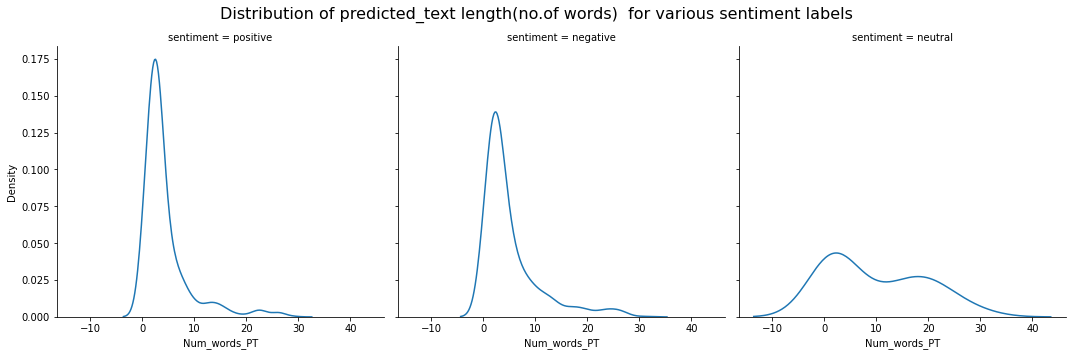

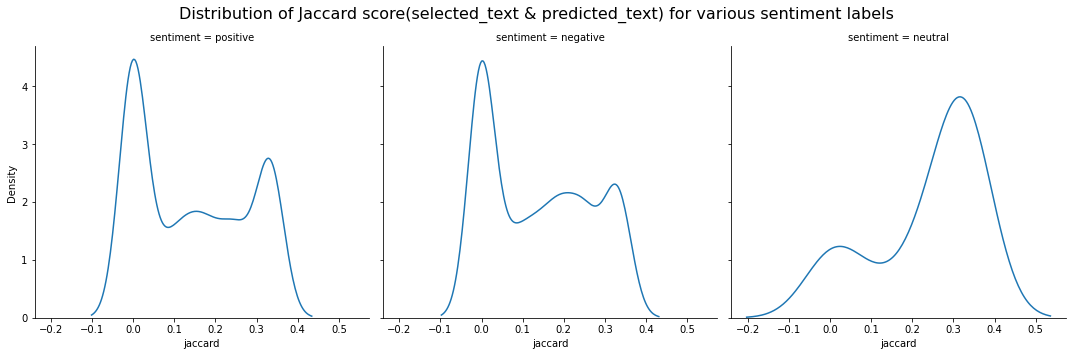

In [ ]:
g=sns.FacetGrid(data=bad,col='sentiment',height=5);
g.map(sns.kdeplot,'Num_words_PT');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of predicted_text length(no.of words)  for various sentiment labels',fontsize=16);

g=sns.FacetGrid(data=bad,col='sentiment',height=5);
g.map(sns.kdeplot,'jaccard');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of Jaccard score(selected_text & predicted_text) for various sentiment labels',fontsize=16);

**observations**

from the predicted text length curves.we can see that positive and negative texts number of words are more likely between **0 to 20 words** unlike neutral text.

from distributions of jaccard scores of selected_text&predicted_text.here also we can see both positive and negative texts have mostly zero densed values unlike netral text

**conclusion**

positive and negative texts have zero neared jaccard scores unlike neutral texts

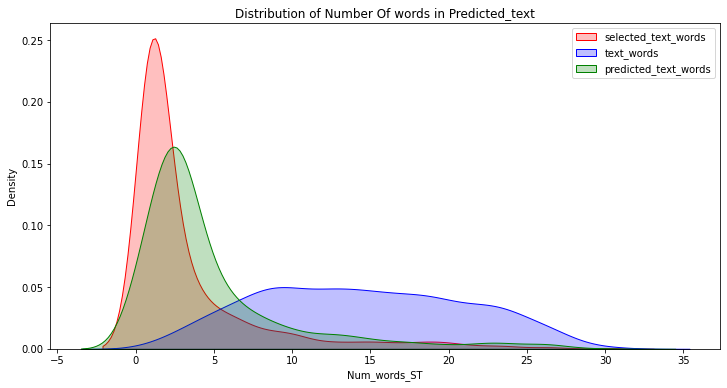

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(bad['Num_words_ST'], shade=True, color="r").set_title('Distribution of Number Of words in Predicted_text')
p1=sns.kdeplot(bad['Num_word_text'], shade=True, color="b") 
p1=sns.kdeplot(bad['Num_words_PT'], shade=True, color="g")
plt.legend(labels=['selected_text_words','text_words','predicted_text_words']) 

**observation**

predicted text and selected text are some what similar distributions  

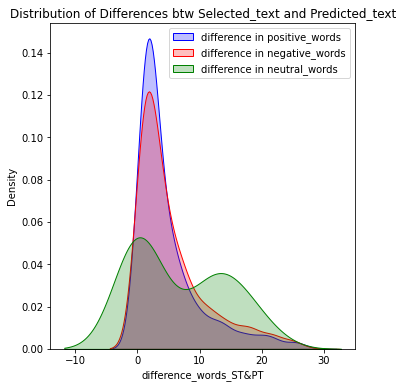

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
p1=sns.kdeplot(bad[bad['sentiment']=='positive']['difference_words_ST&PT'], shade=True, color="b").set_title('Distribution of Differences btw Selected_text and Predicted_text')
p2=sns.kdeplot(bad[bad['sentiment']=='negative']['difference_words_ST&PT'], shade=True, color="r")
p2=sns.kdeplot(bad[bad['sentiment']=='neutral']['difference_words_ST&PT'], shade=True, color="g")
plt.legend(labels=['difference in positive_words','difference in negative_words','difference in neutral_words']) ;


**observations**

here difference represents predicted_text length > selected_text length

distributions of differences(length) of positive and negative texts are right skewed ranging from 0 to 30 words but for neutral text is different

**conclusion**

difference words distribution for positive and negative are very overlapping and right skewed

###**medium**

In [ ]:
medium = x_val[(x_val.jaccard > 1/3)&(x_val.jaccard <= 2/3)]
medium

,text,sentiment,pred_text,selected_text,jaccard,Num_words_PT,Num_words_ST,Num_word_text,difference_in_words,difference_words_ST&PT
8870,elaines my online mommy too she gives good a...,positive,good advice,she gives good advice,0.500000,2,4,9,5,2
6693,there are days of summervac school comes alo...,neutral,there are days of summervac school comes along...,the annual problem of r generation is finding ...,0.590909,24,13,24,11,-11
20672,time for tv in bedthen spending all day catchi...,negative,online summer,i hate online summer classes,0.400000,2,5,17,12,3
2859,soooo happy your back,positive,soooo happy,soooo happy your back,0.500000,2,4,4,0,2
7956,lol its not the army its starfleet rules are ...,negative,lol its not the army its starfleet rules are m...,rules are meant to be broken to get the job done,0.500000,24,11,24,13,-13
...,...,...,...,...,...,...,...,...,...,...
17773,extremly deep,neutral,extremly,extremly deep,0.500000,1,2,2,0,1
1892,missing mrs mcfox,negative,missing mrs,missing,0.500000,2,1,3,2,-1
25589,my brain is gonna explode a minute from now i...,negative,my brain is gonna explode a minute from now it...,my brain is gonna explode a minute from now,0.409091,25,9,25,16,-16
21533,good one,positive,good,good one,0.500000,1,2,2,0,1


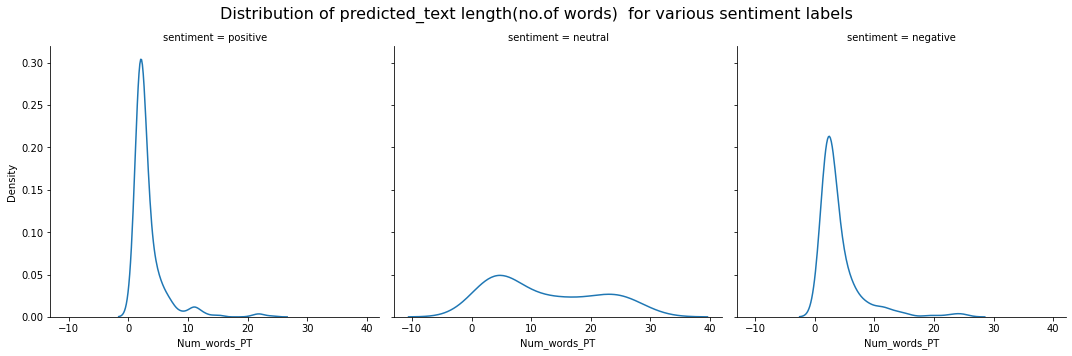

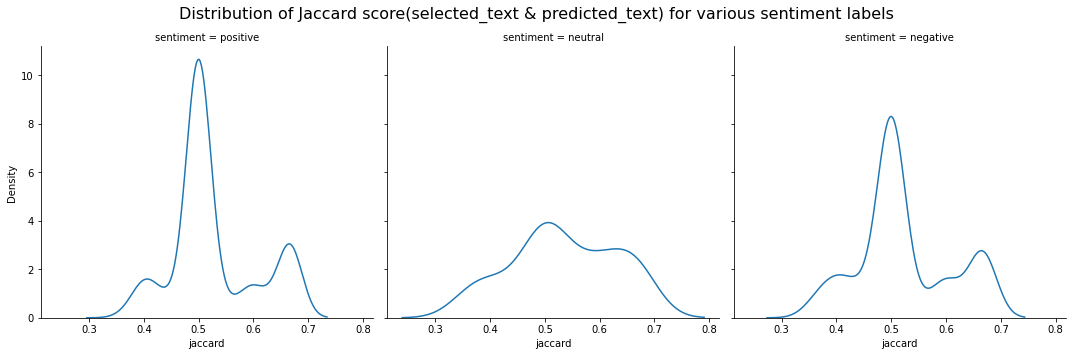

In [ ]:
g=sns.FacetGrid(data=medium,col='sentiment',height=5);
g.map(sns.kdeplot,'Num_words_PT');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of predicted_text length(no.of words)  for various sentiment labels',fontsize=16);

g=sns.FacetGrid(data=medium,col='sentiment',height=5);
g.map(sns.kdeplot,'jaccard');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of Jaccard score(selected_text & predicted_text) for various sentiment labels',fontsize=16);

**observations**

from the predicted text length curves.we can see that positive and negative texts number of words are more likely between **0 to 10 words** unlike neutral text.

from distributions of jaccard scores of selected_text&predicted_text.here 
we can see jaccard scores for each sentiment have mostly **0.5 centered** values 


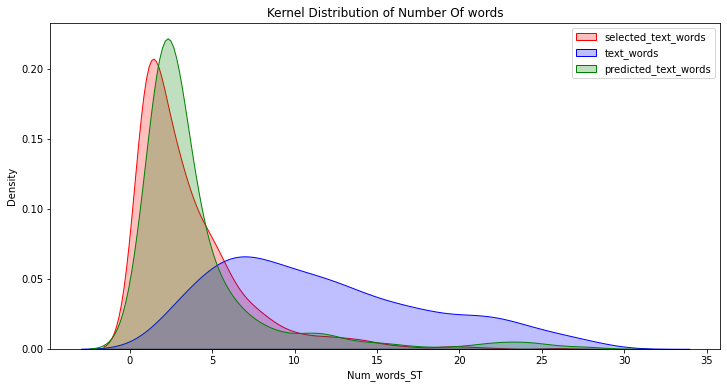

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(medium['Num_words_ST'], shade=True, color="r").set_title('Kernel Distribution of Number Of words')
p1=sns.kdeplot(medium['Num_word_text'], shade=True, color="b")
p1=sns.kdeplot(medium['Num_words_PT'], shade=True, color="g")
plt.legend(labels=['selected_text_words','text_words','predicted_text_words'])

**observation**

selected text and predicted text have almost similar distributions of lenghts

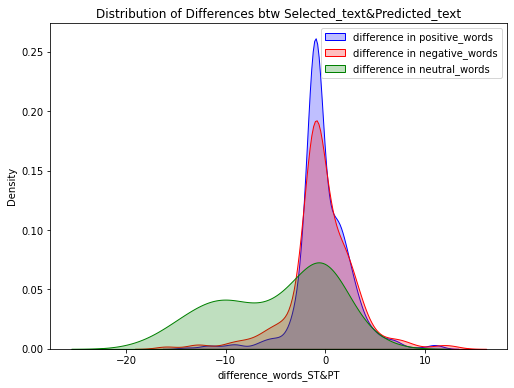

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
p1=sns.kdeplot(medium[medium['sentiment']=='positive']['difference_words_ST&PT'], shade=True, color="b").set_title('Distribution of Differences btw Selected_text&Predicted_text')
p2=sns.kdeplot(medium[medium['sentiment']=='negative']['difference_words_ST&PT'], shade=True, color="r")
p2=sns.kdeplot(medium[medium['sentiment']=='neutral']['difference_words_ST&PT'], shade=True, color="g")
plt.legend(labels=['difference in positive_words','difference in negative_words','difference in neutral_words']) ;

**observations** 

we see more negative values in neutral text which implies predicted_text of neutral text length > selected_text length

difference words lies between -10 to 10 mostly which is better than bad performed data where it was 0 to 30(wide)


###**good**

In [ ]:
good = x_val[x_val.jaccard > 2/3]
good 

,text,sentiment,pred_text,selected_text,jaccard,Num_words_PT,Num_words_ST,Num_word_text,difference_in_words,difference_words_ST&PT
7917,this is my update,neutral,this is my update,this is my update,1.0,4,4,4,0,0
15845,whaaat i still have next week,neutral,whaaat i still have next week,whaaat i still have next week,1.0,6,6,6,0,0
22338,do some research for my article,neutral,do some research for my article,do some research for my article,1.0,6,6,6,0,0
22474,are you okay,neutral,are you okay,are you okay,1.0,3,3,3,0,0
22030,good ABUSE homie hahahahaha thats what im tal...,positive,good,good,1.0,1,1,9,8,0
...,...,...,...,...,...,...,...,...,...,...
27309,the only thing is im not a chocolate fan but...,neutral,the only thing is im not a chocolate fan but t...,the only thing is im not a chocolate fan but ...,1.0,14,14,14,0,0
616,either way you always tend to make my followf...,positive,you do rock that much,you do rock that much,1.0,5,5,16,11,0
4505,awww whered you get that hugh is so thin no ...,neutral,awww whered you get that hugh is so thin no tr...,awww whered you get that hugh is so thin no t...,1.0,22,22,22,0,0
15107,gone to the shiggity shwa back sunday,neutral,gone to the shiggity shwa back sunday,gone to the shiggity shwa back sunday,1.0,7,7,7,0,0


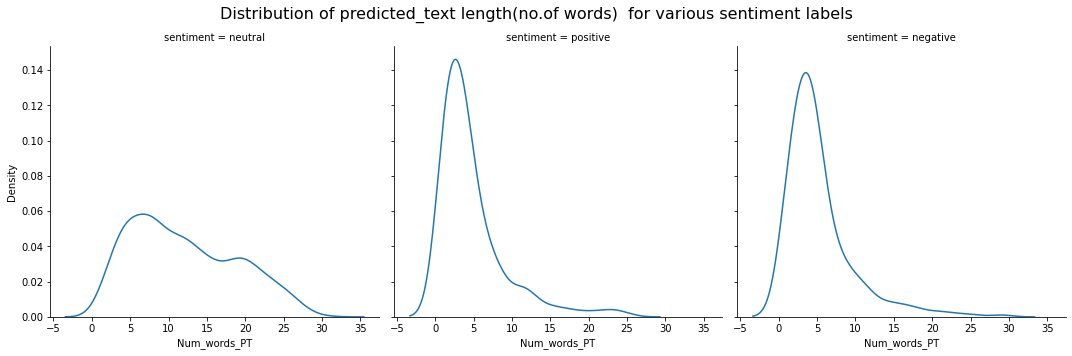

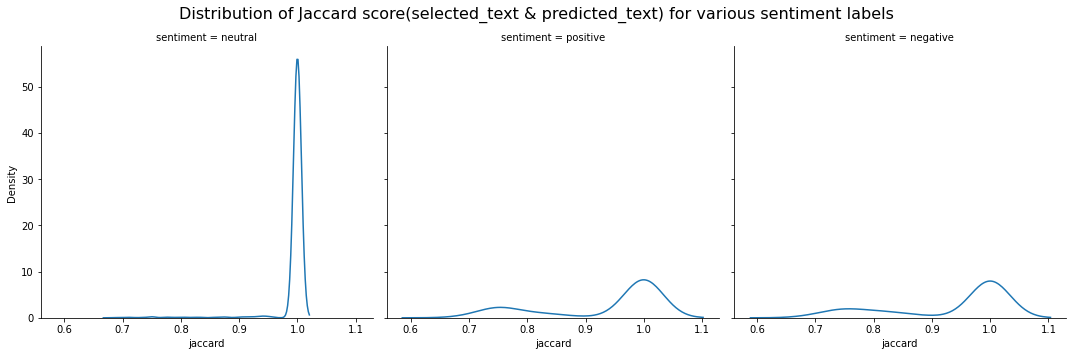

In [ ]:
g=sns.FacetGrid(data=good,col='sentiment',height=5);
g.map(sns.kdeplot,'Num_words_PT');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of predicted_text length(no.of words)  for various sentiment labels',fontsize=16);

g=sns.FacetGrid(data=good,col='sentiment',height=5);
g.map(sns.kdeplot,'jaccard');
plt.subplots_adjust(top=0.87,)
g.fig.suptitle('Distribution of Jaccard score(selected_text & predicted_text) for various sentiment labels',fontsize=16);

**observations**

from the predicted text length curves.we can see that positive and negative texts number of words are more likely between **0 to 10 words** unlike neutral text.

from distributions of jaccard scores of selected_text&predicted_text.here we can see **jaccard scores** for each sentiment have mostly **1.0 centered** values

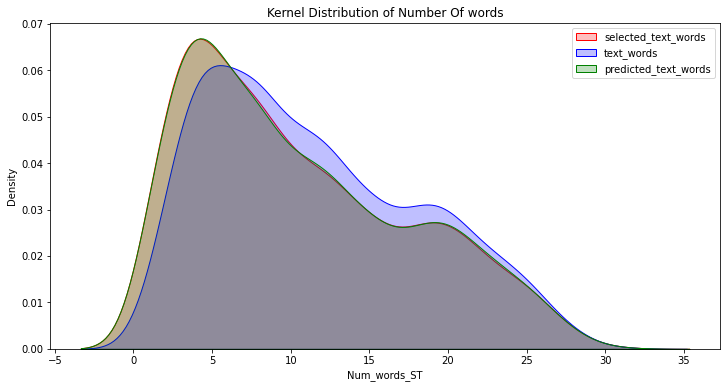

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(good['Num_words_ST'], shade=True, color="r").set_title('Distribution of Number Of words')
p1=sns.kdeplot(good['Num_word_text'], shade=True, color="b")
p1=sns.kdeplot(good['Num_words_PT'], shade=True, color="g")
plt.legend(labels=['selected_text_words','text_words','predicted_text_words'])

**observation**

selected text and predicted text have exact same distribution of lenghts

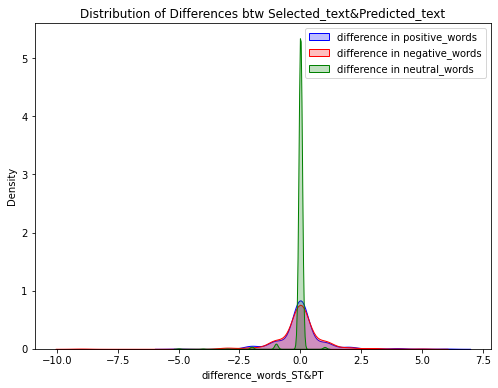

In [ ]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
p1=sns.kdeplot(good[good['sentiment']=='positive']['difference_words_ST&PT'], shade=True, color="b").set_title('Distribution of Differences btw Selected_text&Predicted_text')
p2=sns.kdeplot(good[good['sentiment']=='negative']['difference_words_ST&PT'], shade=True, color="r")
p2=sns.kdeplot(good[good['sentiment']=='neutral']['difference_words_ST&PT'], shade=True, color="g")
plt.legend(labels=['difference in positive_words','difference in negative_words','difference in neutral_words']) ;

**observations**

difference in words is zero centered for all sentiments

positive and negative sentiments have same kind of distribution and lies between -2 to 2 words

by densities of each sentiment. we can say that neutral texts are more 

**conclusion**

difference words are few so jaccard performance is good 

this data is good because of presence of neutral text




**final conclusion**

we can not say lenght of text decides jaccard performance because same selected_text length of 0-20words we are getting 0 to 1 jaccard scores for bad,medium,good data respectively.
